In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, roc_auc_score, average_precision_score
)
from sklearn.utils import class_weight

# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Helper Function for Metrics ---
def calculate_metrics(y_true_indices, y_pred_probs):
    """
    Calculates Accuracy, F1 (Weighted), ROC-AUC (Weighted OVR), and PR-AUC (Weighted).
    y_true_indices: 1D array of class indices
    y_pred_probs: 2D array of probabilities (N, num_classes)
    """
    y_pred_idx = np.argmax(y_pred_probs, axis=1)

    # 1. Accuracy
    acc = accuracy_score(y_true_indices, y_pred_idx)

    # 2. F1 Score
    f1 = f1_score(y_true_indices, y_pred_idx, average='weighted')

    # Create one-hot for AUC metrics
    num_classes = y_pred_probs.shape[1]
    y_true_onehot = np.eye(num_classes)[y_true_indices]

    # 3. ROC-AUC & 4. PR-AUC
    try:
        roc_auc = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='weighted')
        pr_auc = average_precision_score(y_true_onehot, y_pred_probs, average='weighted')
    except ValueError:
        roc_auc = 0.0
        pr_auc = 0.0

    return acc, f1, roc_auc, pr_auc

Using device: cuda


In [19]:
# --- Windowing & Data Parameters ---
SEQUENCE_LENGTH = 150
STRIDE = 10
N_SPLITS = 5
RANDOM_STATE = 42

# --- Training Params ---
CV_EPOCHS = 100
BATCH_SIZE = 128

# --- Reproducibility ---
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [20]:
# --- 1. Load Full Dataset ---
# Ensure 'data/data.xlsx' exists or adjust path
try:
    df_full = pd.read_excel("DataAll.xlsx")
except FileNotFoundError:
    # Dummy generation for testing if file is missing (Remove this block in prod)
    print("File not found. Generating dummy data for demonstration...")
    df_full = pd.DataFrame({
        'Acceleration': np.random.randn(5000),
        'Status': np.random.choice(['A','B','C','D','E'], 5000)
    })

# --- 2. Create Chronological 90/10 Split ---
dev_dfs_list = []
blind_dfs_list = []
# Create groups for contiguous status
df_full['group'] = (df_full['Status'] != df_full['Status'].shift()).cumsum()

for group_id in df_full['group'].unique():
    df_group = df_full[df_full['group'] == group_id]
    split_point = int(0.9 * len(df_group))
    dev_dfs_list.append(df_group.iloc[:split_point])
    blind_dfs_list.append(df_group.iloc[split_point:])

df_dev = pd.concat(dev_dfs_list)
df_blind = pd.concat(blind_dfs_list)

print(f"Original shape: {df_full.shape}")
print(f"df_dev shape:   {df_dev.shape}")
print(f"df_blind shape: {df_blind.shape}")

Original shape: (50000, 4)
df_dev shape:   (45000, 4)
df_blind shape: (5000, 4)


In [21]:
# --- 1. Instantiate Tools ---
encoder = LabelEncoder()
scaler = StandardScaler()

# --- 2. Make Copies ---
df_dev = df_dev.copy()
df_blind = df_blind.copy()

# --- 3. Fit on Dev, Transform Both ---
print("Fitting tools and transforming df_dev...")
df_dev['Status_Encoded'] = encoder.fit_transform(df_dev['Status'])
df_dev['Acceleration_Scaled'] = scaler.fit_transform(df_dev[['Acceleration']])

print("\nTransforming df_blind...")
df_blind['Status_Encoded'] = encoder.transform(df_blind['Status'])
df_blind['Acceleration_Scaled'] = scaler.transform(df_blind[['Acceleration']])

# --- 4. Store Classes ---
num_classes = len(encoder.classes_)
print(f"\nClasses found ({num_classes}): {encoder.classes_}")

Fitting tools and transforming df_dev...

Transforming df_blind...

Classes found (5): ['CVF' 'GOOD' 'IOVF' 'IVF' 'OVF']


In [22]:
def create_windows(df, seq_length, stride, feature_col, label_col, group_col):
    scaled_features = df[feature_col].values
    labels = df[label_col].values
    groups = df[group_col].values

    starts = np.arange(0, len(df) - seq_length + 1, stride)
    ends = starts + seq_length - 1
    valid_starts = starts[groups[starts] == groups[ends]]

    # Shape: (N, 150, 1)
    X = np.empty((len(valid_starts), seq_length, 1), dtype=np.float32)
    y = np.empty(len(valid_starts), dtype=np.int64) # int64 for PyTorch Labels

    for i, start_index in enumerate(valid_starts):
        end_index = start_index + seq_length
        X[i] = scaled_features[start_index:end_index].reshape(seq_length, 1)
        y[i] = labels[start_index]
    return X, y

# --- Create Windowed Datasets ---
print("--- Creating STRIDED windows for df_dev ---\n")
X_dev, y_dev = create_windows(
    df_dev, SEQUENCE_LENGTH, STRIDE,
    'Acceleration_Scaled', 'Status_Encoded', 'group'
)
print(f"X_dev shape: {X_dev.shape}, y_dev shape: {y_dev.shape}")

print("\n--- Creating STRIDED windows for df_blind ---\n")
X_blind, y_blind = create_windows(
    df_blind, SEQUENCE_LENGTH, STRIDE,
    'Acceleration_Scaled', 'Status_Encoded', 'group'
)
print(f"X_blind shape: {X_blind.shape}, y_blind shape: {y_blind.shape}")

--- Creating STRIDED windows for df_dev ---

X_dev shape: (4430, 150, 1), y_dev shape: (4430,)

--- Creating STRIDED windows for df_blind ---

X_blind shape: (430, 150, 1), y_blind shape: (430,)


In [23]:
# --- Calculate Class Weights ---
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_dev),
    y=y_dev
)
# Convert to tensor for Loss function
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Using class weights: {class_weights}")

# --- PyTorch Dataset Class ---
class SensorDataset(Dataset):
    def __init__(self, X, y):
        # PyTorch Conv1d expects (Batch, Channels, Length)
        # Our X is (Batch, Length, Channels). We permute to (Batch, 1, 150)
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

results = {} # To store final metrics

Using class weights: [1. 1. 1. 1. 1.]


In [24]:
# --- Model 1 (Baseline BiGRU) ---
class Model1_BiGRU(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model1_BiGRU, self).__init__()
        # Input comes in as (N, 1, 150). RNN wants (N, 150, 1)

        self.gru1 = nn.GRU(input_size=1, hidden_size=64, bidirectional=True, batch_first=True)
        self.bn1 = nn.BatchNorm1d(150) # BN on Sequence Length
        self.dropout1 = nn.Dropout(0.3)

        self.gru2 = nn.GRU(input_size=128, hidden_size=32, bidirectional=True, batch_first=True)
        self.bn2 = nn.BatchNorm1d(150)
        self.dropout2 = nn.Dropout(0.3)

        # Flatten logic for RNN return_sequences=False equivalent
        # We take the last time step of the sequence
        self.fc1 = nn.Linear(64, 64) # 32*2 directions
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (N, 1, 150) -> permute to (N, 150, 1) for RNN
        x = x.permute(0, 2, 1)

        x, _ = self.gru1(x) # Output: (N, 150, 128)
        x = self.bn1(x)
        x = self.dropout1(x)

        # Keras return_sequences=False in second layer means we take the last step?
        # The original code had return_sequences=False in the 2nd GRU.
        # However, BN implies we process the sequence.
        # Let's apply GRU2 over sequence then take last step.
        x, _ = self.gru2(x) # Output: (N, 150, 64)
        x = self.bn2(x)
        x = self.dropout2(x)

        # Take last time step: equivalent to return_sequences=False
        x = x[:, -1, :]

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        logits = self.fc2(x)
        return logits

# --- Model 2 (Conv1D + GRU) ---
class Model2_ConvGRU(nn.Module):
    def __init__(self, num_classes):
        super(Model2_ConvGRU, self).__init__()
        # Input (N, 1, 150)

        # Keras: Conv1D(64, 7, padding='same')
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.drop2 = nn.Dropout(0.2)

        # GRU Input: needs (N, L, C). Current is (N, C, L)
        self.gru = nn.GRU(128, 64, batch_first=True)
        self.drop3 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(64, 64)
        self.tanh = nn.Tanh()
        self.drop4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Block 1
        x = torch.tanh(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.drop1(x)

        # Block 2
        x = torch.tanh(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.drop2(x)

        # Prep for GRU: (N, C, L) -> (N, L, C)
        x = x.permute(0, 2, 1)

        x, _ = self.gru(x)
        x = x[:, -1, :] # Last time step
        x = self.drop3(x)

        x = self.tanh(self.fc1(x))
        x = self.drop4(x)
        return self.fc2(x)

# --- Model 3 (Proposed Reg) ---
class Model3_Proposed(nn.Module):
    def __init__(self, num_classes):
        super(Model3_Proposed, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(64, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.drop2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.drop3 = nn.Dropout(0.2)

        self.gru = nn.GRU(256, 64, bidirectional=True, batch_first=True)
        self.drop4 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(128, 64) # 64*2 from BiGRU
        self.tanh = nn.Tanh()
        self.drop5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = torch.tanh(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = torch.tanh(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = x.permute(0, 2, 1) # (N, L, C)

        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.drop4(x)

        x = self.tanh(self.fc1(x))
        x = self.drop5(x)
        return self.fc2(x)

# --- Model 4 (No Reg) ---
class Model4_NoReg(nn.Module):
    def __init__(self, num_classes):
        super(Model4_NoReg, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, 5, padding=2)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.pool3 = nn.MaxPool1d(2)

        self.gru = nn.GRU(256, 64, bidirectional=True, batch_first=True)

        self.fc1 = nn.Linear(128, 64)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)

        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)

        x = torch.tanh(self.conv3(x))
        x = self.pool3(x)

        x = x.permute(0, 2, 1)

        x, _ = self.gru(x)
        x = x[:, -1, :]

        x = self.tanh(self.fc1(x))
        return self.fc2(x)

print("All 4 PyTorch models defined.")

All 4 PyTorch models defined.


In [25]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_weights(self, model):
        model.load_state_dict(self.best_model_state)

def train_model(model, train_loader, val_loader, epochs, class_weights, patience=5):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
    early_stopping = EarlyStopping(patience=patience)

    history = {'loss': [], 'val_loss': [], 'accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        history['val_loss'].append(val_loss)

        # LR Schedule & Early Stop
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            # print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best weights
    early_stopping.load_best_weights(model)
    return history, len(history['loss'])

def evaluate_model(model, loader):
    model.eval()
    all_probs = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    avg_loss = total_loss / len(loader.dataset)

    return all_labels, all_probs, avg_loss

In [26]:
print("--- Starting CV for Model 1: Baseline BiGRU ---")
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
fold_epochs_1 = []
cv_scores = {'acc': [], 'f1': [], 'roc_auc': [], 'pr_auc': []}

for f, (tr_idx, va_idx) in enumerate(skf.split(X_dev, y_dev)):
    print(f"  Fold {f+1}/{N_SPLITS}...")

    # Datasets
    train_ds = SensorDataset(X_dev[tr_idx], y_dev[tr_idx])
    val_ds = SensorDataset(X_dev[va_idx], y_dev[va_idx])

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    # Init Model
    model = Model1_BiGRU(input_size=1, num_classes=num_classes).to(device)

    # Train
    hist, best_epoch = train_model(model, train_loader, val_loader, CV_EPOCHS, class_weights_tensor)
    fold_epochs_1.append(best_epoch)

    # Evaluate
    y_true, y_probs, _ = evaluate_model(model, val_loader)
    acc, f1, roc, pr = calculate_metrics(y_true, y_probs)

    cv_scores['acc'].append(acc)
    cv_scores['f1'].append(f1)
    cv_scores['roc_auc'].append(roc)
    cv_scores['pr_auc'].append(pr)

FINAL_EPOCHS_MODEL_1 = int(np.ceil(np.mean(fold_epochs_1)))

print(f"\n=== CV Summary (Model 1) ===")
print(f"Recommended Epochs: {FINAL_EPOCHS_MODEL_1}")
print(f"CV Accuracy: {np.mean(cv_scores['acc']):.4f}")
print(f"CV F1 Score: {np.mean(cv_scores['f1']):.4f}")
print(f"CV ROC-AUC:  {np.mean(cv_scores['roc_auc']):.4f}")
print(f"CV PR-AUC:   {np.mean(cv_scores['pr_auc']):.4f}")

--- Starting CV for Model 1: Baseline BiGRU ---
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== CV Summary (Model 1) ===
Recommended Epochs: 62
CV Accuracy: 0.8325
CV F1 Score: 0.8281
CV ROC-AUC:  0.9674
CV PR-AUC:   0.9039


In [27]:
print(f"\n--- Training final Model 1 for {FINAL_EPOCHS_MODEL_1} epochs ---\n")

# Full Dev Dataset
full_train_ds = SensorDataset(X_dev, y_dev)
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
blind_ds = SensorDataset(X_blind, y_blind)
blind_loader = DataLoader(blind_ds, batch_size=BATCH_SIZE, shuffle=False)

# Retrain
final_model_1 = Model1_BiGRU(1, num_classes).to(device)
# Create a dummy val loader (using blind set to track progress, though technically should just train)
history_1, _ = train_model(final_model_1, full_train_loader, blind_loader, FINAL_EPOCHS_MODEL_1, class_weights_tensor, patience=999)

print("\n--- BLIND TEST EVALUATION (Model 1) ---")
y_true_1, y_probs_1, loss_1 = evaluate_model(final_model_1, blind_loader)
y_pred_1 = np.argmax(y_probs_1, axis=1)

b_acc, b_f1, b_roc, b_pr = calculate_metrics(y_true_1, y_probs_1)

results['Model 1'] = {
    'name': 'Baseline BiGRU',
    'epochs': FINAL_EPOCHS_MODEL_1,
    'loss': loss_1,
    'accuracy': b_acc,
    'f1': b_f1,
    'roc_auc': b_roc,
    'pr_auc': b_pr,
    'history': history_1,
    'y_pred': y_pred_1
}

print(f"Blind Test Loss:     {loss_1:.4f}")
print(f"Blind Test Accuracy: {b_acc:.4f}")
print(f"Blind Test F1:       {b_f1:.4f}")
print(classification_report(y_true_1, y_pred_1, target_names=encoder.classes_))


--- Training final Model 1 for 62 epochs ---


--- BLIND TEST EVALUATION (Model 1) ---
Blind Test Loss:     0.6524
Blind Test Accuracy: 0.7442
Blind Test F1:       0.7361
              precision    recall  f1-score   support

         CVF       0.82      0.57      0.67        86
        GOOD       0.55      0.59      0.57        86
        IOVF       0.69      0.57      0.62        86
         IVF       0.93      1.00      0.97        86
         OVF       0.74      0.99      0.85        86

    accuracy                           0.74       430
   macro avg       0.75      0.74      0.74       430
weighted avg       0.75      0.74      0.74       430



In [28]:
print("--- Starting CV for Model 2: Conv1D+GRU ---")
fold_epochs_2 = []
cv_scores_2 = {'acc': [], 'f1': [], 'roc_auc': [], 'pr_auc': []}

for f, (tr_idx, va_idx) in enumerate(skf.split(X_dev, y_dev)):
    print(f"  Fold {f+1}/{N_SPLITS}...")

    train_loader = DataLoader(SensorDataset(X_dev[tr_idx], y_dev[tr_idx]), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(SensorDataset(X_dev[va_idx], y_dev[va_idx]), batch_size=BATCH_SIZE)

    model = Model2_ConvGRU(num_classes).to(device)
    hist, best_epoch = train_model(model, train_loader, val_loader, CV_EPOCHS, class_weights_tensor)
    fold_epochs_2.append(best_epoch)

    y_true, y_probs, _ = evaluate_model(model, val_loader)
    acc, f1, roc, pr = calculate_metrics(y_true, y_probs)

    cv_scores_2['acc'].append(acc)
    cv_scores_2['f1'].append(f1)
    cv_scores_2['roc_auc'].append(roc)
    cv_scores_2['pr_auc'].append(pr)

FINAL_EPOCHS_MODEL_2 = int(np.ceil(np.mean(fold_epochs_2)))
print(f"\n=== CV Summary (Model 2) ===")
print(f"Recommended Epochs: {FINAL_EPOCHS_MODEL_2}")
print(f"CV Accuracy: {np.mean(cv_scores_2['acc']):.4f}")
print(f"CV F1 Score: {np.mean(cv_scores_2['f1']):.4f}")

--- Starting CV for Model 2: Conv1D+GRU ---
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== CV Summary (Model 2) ===
Recommended Epochs: 39
CV Accuracy: 0.9953
CV F1 Score: 0.9953


In [29]:
print(f"\n--- Training final Model 2 for {FINAL_EPOCHS_MODEL_2} epochs ---\n")
final_model_2 = Model2_ConvGRU(num_classes).to(device)
history_2, _ = train_model(final_model_2, full_train_loader, blind_loader, FINAL_EPOCHS_MODEL_2, class_weights_tensor, patience=999)

y_true_2, y_probs_2, loss_2 = evaluate_model(final_model_2, blind_loader)
y_pred_2 = np.argmax(y_probs_2, axis=1)
b_acc, b_f1, b_roc, b_pr = calculate_metrics(y_true_2, y_probs_2)

results['Model 2'] = {
    'name': 'Conv1D+GRU',
    'epochs': FINAL_EPOCHS_MODEL_2,
    'loss': loss_2,
    'accuracy': b_acc,
    'f1': b_f1,
    'roc_auc': b_roc,
    'pr_auc': b_pr,
    'history': history_2,
    'y_pred': y_pred_2
}
print(f"Blind Test Accuracy: {b_acc:.4f}")
print(f"Blind Test F1:       {b_f1:.4f}")
print(classification_report(y_true_2, y_pred_2, target_names=encoder.classes_))


--- Training final Model 2 for 39 epochs ---

Blind Test Accuracy: 0.9140
Blind Test F1:       0.9130
              precision    recall  f1-score   support

         CVF       0.78      0.97      0.86        86
        GOOD       0.93      0.73      0.82        86
        IOVF       0.99      0.87      0.93        86
         IVF       1.00      1.00      1.00        86
         OVF       0.92      1.00      0.96        86

    accuracy                           0.91       430
   macro avg       0.92      0.91      0.91       430
weighted avg       0.92      0.91      0.91       430



In [30]:
print("--- Starting CV for Model 3: Proposed ---")
fold_epochs_3 = []
cv_scores_3 = {'acc': [], 'f1': [], 'roc_auc': [], 'pr_auc': []}

for f, (tr_idx, va_idx) in enumerate(skf.split(X_dev, y_dev)):
    print(f"  Fold {f+1}/{N_SPLITS}...")
    train_loader = DataLoader(SensorDataset(X_dev[tr_idx], y_dev[tr_idx]), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(SensorDataset(X_dev[va_idx], y_dev[va_idx]), batch_size=BATCH_SIZE)

    model = Model3_Proposed(num_classes).to(device)
    hist, best_epoch = train_model(model, train_loader, val_loader, CV_EPOCHS, class_weights_tensor)
    fold_epochs_3.append(best_epoch)

    y_true, y_probs, _ = evaluate_model(model, val_loader)
    acc, f1, roc, pr = calculate_metrics(y_true, y_probs)
    cv_scores_3['acc'].append(acc)
    cv_scores_3['f1'].append(f1)
    cv_scores_3['roc_auc'].append(roc)
    cv_scores_3['pr_auc'].append(pr)

FINAL_EPOCHS_MODEL_3 = int(np.ceil(np.mean(fold_epochs_3)))
print(f"\n=== CV Summary (Model 3) ===")
print(f"Recommended Epochs: {FINAL_EPOCHS_MODEL_3}")
print(f"CV Accuracy: {np.mean(cv_scores_3['acc']):.4f}")

--- Starting CV for Model 3: Proposed ---
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== CV Summary (Model 3) ===
Recommended Epochs: 37
CV Accuracy: 0.9982


In [31]:
print(f"\n--- Training final Model 3 for {FINAL_EPOCHS_MODEL_3} epochs ---\n")
final_model_3 = Model3_Proposed(num_classes).to(device)
history_3, _ = train_model(final_model_3, full_train_loader, blind_loader, FINAL_EPOCHS_MODEL_3, class_weights_tensor, patience=999)

y_true_3, y_probs_3, loss_3 = evaluate_model(final_model_3, blind_loader)
y_pred_3 = np.argmax(y_probs_3, axis=1)
b_acc, b_f1, b_roc, b_pr = calculate_metrics(y_true_3, y_probs_3)

results['Model 3'] = {
    'name': 'Proposed (Conv+BiGRU)',
    'epochs': FINAL_EPOCHS_MODEL_3,
    'loss': loss_3,
    'accuracy': b_acc,
    'f1': b_f1,
    'roc_auc': b_roc,
    'pr_auc': b_pr,
    'history': history_3,
    'y_pred': y_pred_3
}
print(f"Blind Test Accuracy: {b_acc:.4f}")
print(classification_report(y_true_3, y_pred_3, target_names=encoder.classes_))


--- Training final Model 3 for 37 epochs ---

Blind Test Accuracy: 0.9186
              precision    recall  f1-score   support

         CVF       0.80      0.98      0.88        86
        GOOD       0.93      0.76      0.83        86
        IOVF       1.00      0.87      0.93        86
         IVF       1.00      1.00      1.00        86
         OVF       0.90      0.99      0.94        86

    accuracy                           0.92       430
   macro avg       0.93      0.92      0.92       430
weighted avg       0.93      0.92      0.92       430



In [32]:
print("--- Starting CV for Model 4: No Regularization ---")
fold_epochs_4 = []
cv_scores_4 = {'acc': [], 'f1': [], 'roc_auc': [], 'pr_auc': []}

for f, (tr_idx, va_idx) in enumerate(skf.split(X_dev, y_dev)):
    print(f"  Fold {f+1}/{N_SPLITS}...")
    train_loader = DataLoader(SensorDataset(X_dev[tr_idx], y_dev[tr_idx]), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(SensorDataset(X_dev[va_idx], y_dev[va_idx]), batch_size=BATCH_SIZE)

    model = Model4_NoReg(num_classes).to(device)
    hist, best_epoch = train_model(model, train_loader, val_loader, CV_EPOCHS, class_weights_tensor)
    fold_epochs_4.append(best_epoch)

    y_true, y_probs, _ = evaluate_model(model, val_loader)
    acc, f1, roc, pr = calculate_metrics(y_true, y_probs)
    cv_scores_4['acc'].append(acc)
    cv_scores_4['f1'].append(f1)
    cv_scores_4['roc_auc'].append(roc)
    cv_scores_4['pr_auc'].append(pr)

FINAL_EPOCHS_MODEL_4 = int(np.ceil(np.mean(fold_epochs_4)))
print(f"\n=== CV Summary (Model 4) ===")
print(f"Recommended Epochs: {FINAL_EPOCHS_MODEL_4}")
print(f"CV Accuracy: {np.mean(cv_scores_4['acc']):.4f}")

--- Starting CV for Model 4: No Regularization ---
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== CV Summary (Model 4) ===
Recommended Epochs: 63
CV Accuracy: 0.9885


In [33]:
print(f"\n--- Training final Model 4 for {FINAL_EPOCHS_MODEL_4} epochs ---\n")
final_model_4 = Model4_NoReg(num_classes).to(device)
history_4, _ = train_model(final_model_4, full_train_loader, blind_loader, FINAL_EPOCHS_MODEL_4, class_weights_tensor, patience=999)

y_true_4, y_probs_4, loss_4 = evaluate_model(final_model_4, blind_loader)
y_pred_4 = np.argmax(y_probs_4, axis=1)
b_acc, b_f1, b_roc, b_pr = calculate_metrics(y_true_4, y_probs_4)

results['Model 4'] = {
    'name': 'Proposed (No Reg)',
    'epochs': FINAL_EPOCHS_MODEL_4,
    'loss': loss_4,
    'accuracy': b_acc,
    'f1': b_f1,
    'roc_auc': b_roc,
    'pr_auc': b_pr,
    'history': history_4,
    'y_pred': y_pred_4
}
print(f"Blind Test Accuracy: {b_acc:.4f}")
print(classification_report(y_true_4, y_pred_4, target_names=encoder.classes_))


--- Training final Model 4 for 63 epochs ---

Blind Test Accuracy: 0.9326
              precision    recall  f1-score   support

         CVF       0.85      0.91      0.88        86
        GOOD       0.90      0.84      0.87        86
        IOVF       0.99      0.93      0.96        86
         IVF       1.00      1.00      1.00        86
         OVF       0.93      0.99      0.96        86

    accuracy                           0.93       430
   macro avg       0.93      0.93      0.93       430
weighted avg       0.93      0.93      0.93       430



--- 📊 Final Blind Test Comparison ---
                          name  epochs  accuracy        f1   roc_auc  \
Model 1         Baseline BiGRU      62  0.744186  0.736107  0.933295   
Model 2             Conv1D+GRU      39  0.913953  0.913021  0.984613   
Model 3  Proposed (Conv+BiGRU)      37  0.918605  0.917807  0.991563   
Model 4      Proposed (No Reg)      63  0.932558  0.932482  0.984208   

           pr_auc      loss  
Model 1  0.814786  0.652372  
Model 2  0.947531  0.317660  
Model 3  0.968838  0.227505  
Model 4  0.938909  0.258501  

--- 📈 Final Training Histories ---


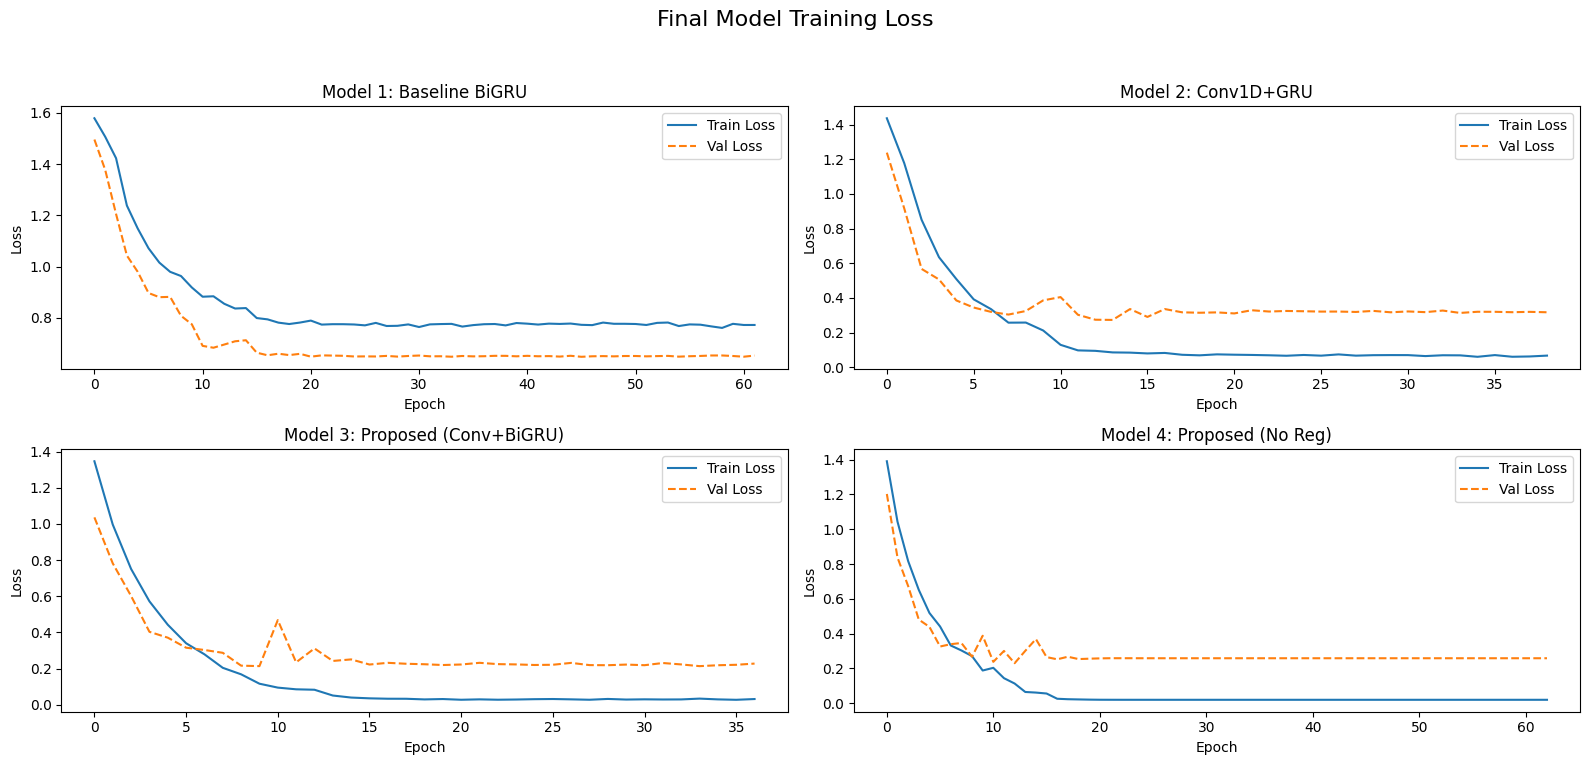


--- Blind Test Confusion Matrices ---


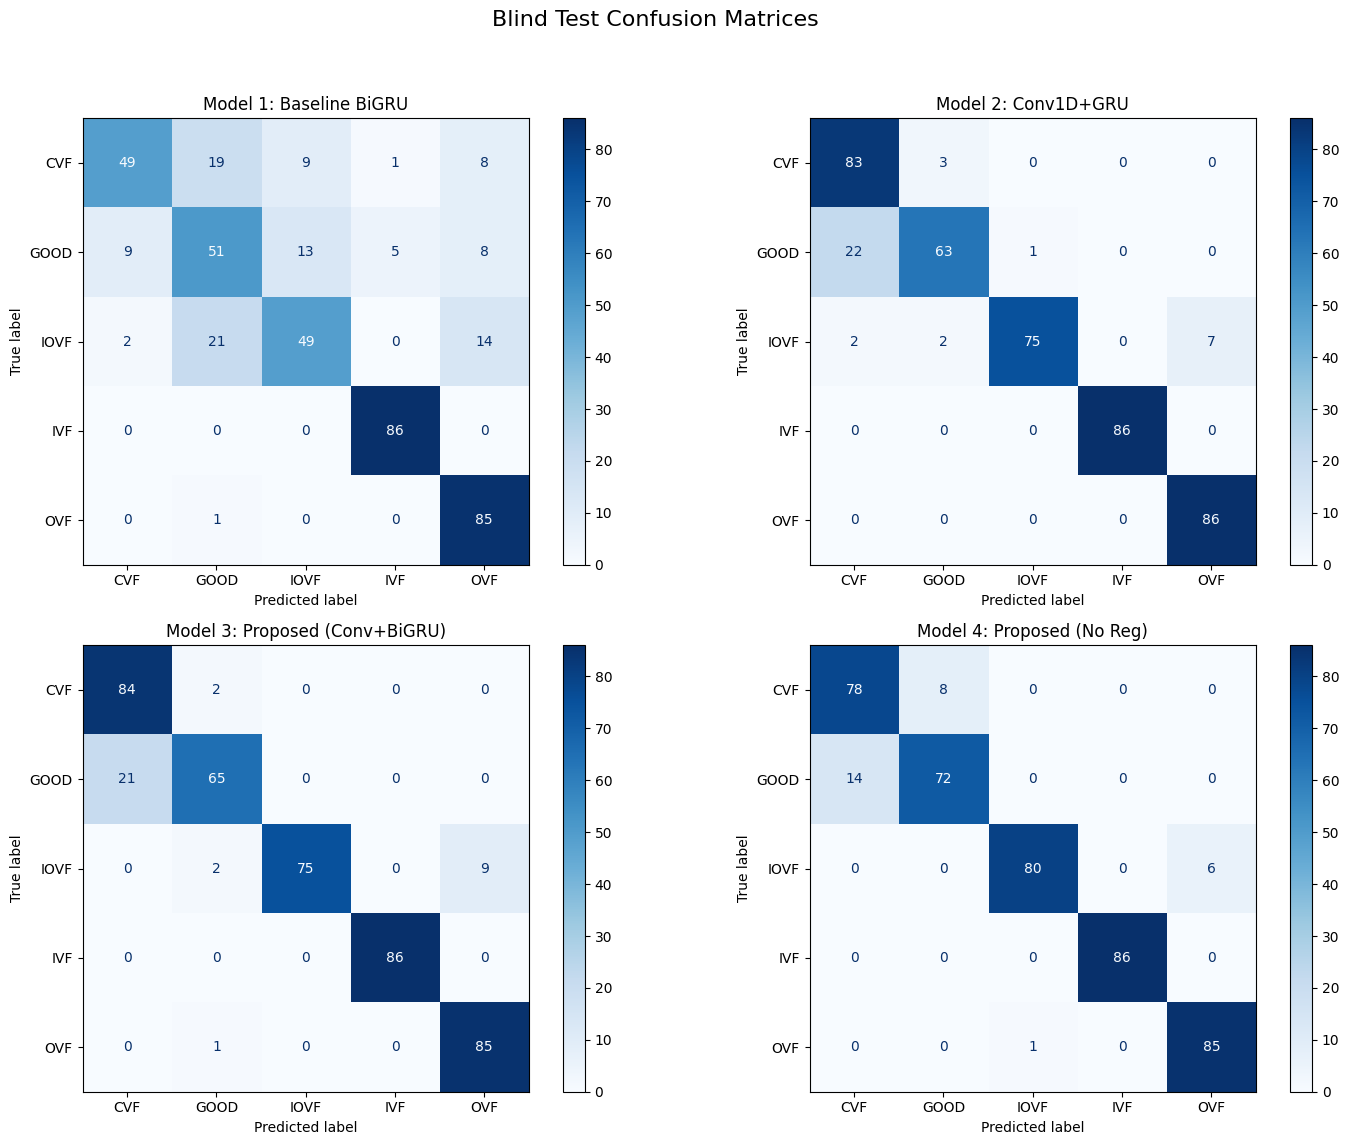

In [34]:
# --- 1. Summary Metrics Table ---
print("--- 📊 Final Blind Test Comparison ---")
results_df = pd.DataFrame.from_dict(results, orient='index')
display_cols = ['name', 'epochs', 'accuracy', 'f1', 'roc_auc', 'pr_auc', 'loss']
print(results_df[display_cols])

# --- 2. Training History Plots (Loss & Accuracy) ---
print("\n--- 📈 Final Training Histories ---")

plt.figure(figsize=(16, 8))
plt.suptitle("Final Model Training Loss", fontsize=16)
for i, (model_id, data) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)
    plt.plot(data['history']['loss'], label='Train Loss')
    plt.plot(data['history']['val_loss'], label='Val Loss', linestyle='--')
    plt.title(f"{model_id}: {data['name']}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 3. Blind Test Confusion Matrices ---
print("\n--- Blind Test Confusion Matrices ---")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.suptitle("Blind Test Confusion Matrices", fontsize=16)
axes = axes.flatten()

# y_true is the same for all (blind set)
y_true_classes = y_blind

for i, (model_id, data) in enumerate(results.items()):
    cm = confusion_matrix(y_true_classes, data['y_pred'])
    disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
    disp.plot(ax=axes[i], cmap=plt.cm.Blues)
    axes[i].set_title(f"{model_id}: {data['name']}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()